In [1]:
# %% [markdown]
# # Titanic: End-to-End Notebook
# 
# Instructions:
# 1. Put train.csv, test.csv, gender_submission.csv in one folder.
# 2. Replace DATA_DIR below with that folder path (use raw string r"..." on Windows).
# 3. Run cells in order.
#
# If any cell errors, paste the error here and I'll help debug.


In [2]:
# %% [markdown]
# ## 0) Set data folder
# Replace the example path below with your folder path.


In [4]:
# %%
import os
import sys
# Example:
# DATA_DIR = r"C:\Users\Prajwal\Downloads\titanic-data"   # Windows example (use r"")
# DATA_DIR = "/home/prajwal/datasets/titanic"            # macOS / Linux example

DATA_DIR = r"C:\Users\Prajwal\Downloads\titanic"  # <-- REPLACE this with your folder path

TRAIN_FILE = os.path.join(DATA_DIR, "train.csv")
TEST_FILE = os.path.join(DATA_DIR, "test.csv")
SAMPLE_FILE = os.path.join(DATA_DIR, "gender_submission.csv")

# Validate paths
for p in (TRAIN_FILE, TEST_FILE, SAMPLE_FILE):
    if not os.path.exists(p):
        print(f"ERROR: file not found: {p}")
        print("Please check DATA_DIR and filenames, then re-run this cell.")
        # Stop further execution in the notebook flow intentionally so user fixes path
        raise FileNotFoundError(p)

print("All files found. Ready to proceed.")
print("Train:", TRAIN_FILE)
print("Test: ", TEST_FILE)
print("Sample:", SAMPLE_FILE)


All files found. Ready to proceed.
Train: C:\Users\Prajwal\Downloads\titanic\train.csv
Test:  C:\Users\Prajwal\Downloads\titanic\test.csv
Sample: C:\Users\Prajwal\Downloads\titanic\gender_submission.csv


In [5]:
# %% [markdown]
# ## 1) Imports & settings


In [6]:
# %%
# Basic imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn & others
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib

# xgboost (optional)
try:
    from xgboost import XGBClassifier
    _has_xgb = True
except Exception:
    _has_xgb = False

# display settings
%matplotlib inline
sns.set_style("whitegrid")
pd.set_option("display.max_columns", 200)
print("xgboost available:", _has_xgb)


xgboost available: False


In [7]:
# %% [markdown]
# ## 2) Load data (from DATA_DIR)


In [8]:
# %%
train = pd.read_csv(TRAIN_FILE)
test = pd.read_csv(TEST_FILE)
sample_sub = pd.read_csv(SAMPLE_FILE)

print("Train shape:", train.shape)
print("Test shape: ", test.shape)
train.head()


Train shape: (891, 12)
Test shape:  (418, 11)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [9]:
# %% [markdown]
# ## 3) Quick EDA


Missing values in train:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


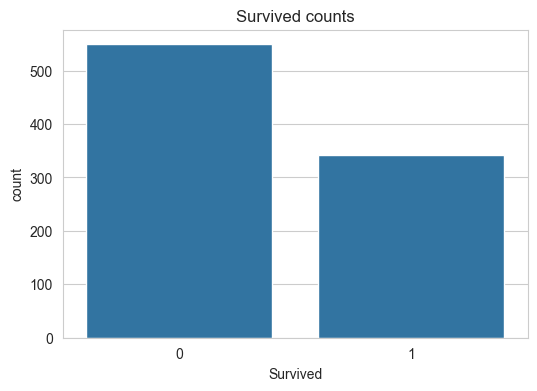

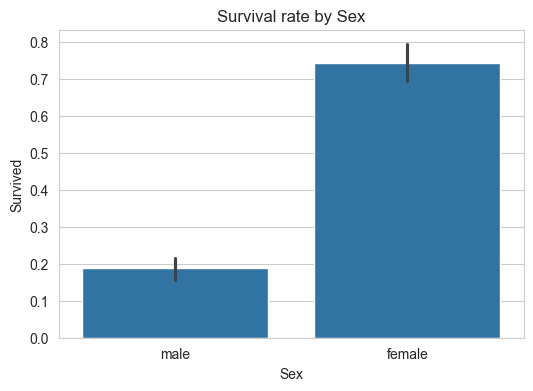

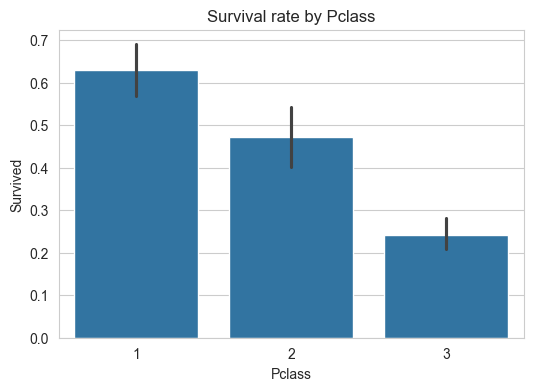

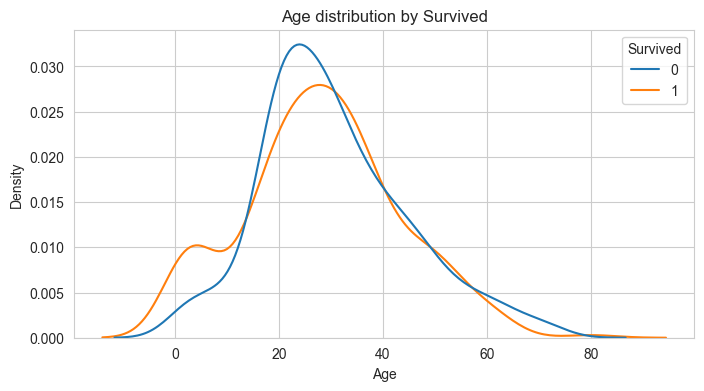

In [10]:
# %%
# Missing values
print("Missing values in train:")
print(train.isnull().sum())

# Quick plots
plt.figure(figsize=(6,4))
sns.countplot(data=train, x="Survived")
plt.title("Survived counts")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=train, x="Sex", y="Survived")
plt.title("Survival rate by Sex")
plt.show()

plt.figure(figsize=(6,4))
sns.barplot(data=train, x="Pclass", y="Survived")
plt.title("Survival rate by Pclass")
plt.show()

plt.figure(figsize=(8,4))
sns.kdeplot(data=train, x="Age", hue="Survived", common_norm=False)
plt.title("Age distribution by Survived")
plt.show()


In [11]:
# %% [markdown]
# ## 4) Feature engineering function
# This creates Title, FamilySize, IsAlone, FarePerPerson, Deck, AgeBin.


In [12]:
# %%
def feature_engineer(df):
    df = df.copy()
    # Title
    df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False)
    df['Title'] = df['Title'].replace(['Mlle','Ms','Mme'], ['Miss','Miss','Mrs'])
    rare_titles = ['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona']
    df['Title'] = df['Title'].replace(rare_titles, 'Rare')
    # Family size
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    # Fare per person (handle zero division)
    df['Fare'] = df['Fare'].fillna(df['Fare'].median())
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']
    # Cabin -> Deck
    df['Cabin'] = df['Cabin'].fillna('U')
    df['Deck'] = df['Cabin'].str[0]
    # Age fill (temporary) and AgeBin
    df['Age'] = df['Age'].fillna(df['Age'].median())
    df['AgeBin'] = pd.cut(df['Age'], bins=[0,12,20,40,60,120], labels=['Child','Teen','Adult','Middle','Senior'])
    return df

train_fe = feature_engineer(train)
test_fe = feature_engineer(test)

# Quick peek
train_fe[['PassengerId','Title','FamilySize','IsAlone','FarePerPerson','Deck','Age','AgeBin']].head()


,PassengerId,Title,FamilySize,IsAlone,FarePerPerson,Deck,Age,AgeBin
0,1,Mr,2,0,3.62500,U,22.0,Adult
1,2,Mrs,2,0,35.64165,C,38.0,Adult
2,3,Miss,1,1,7.92500,U,26.0,Adult
3,4,Mrs,2,0,26.55000,C,35.0,Adult
4,5,Mr,1,1,8.05000,U,35.0,Adult


In [13]:
# %% [markdown]
# ## 5) Select features for modeling


In [14]:
# %%
num_cols = ['Age','Fare','FamilySize','FarePerPerson']
cat_cols = ['Pclass','Sex','Embarked','Title','IsAlone','Deck','AgeBin']

# Safety: ensure columns exist
for col in num_cols + cat_cols:
    if col not in train_fe.columns:
        raise KeyError(f"Missing column in engineered train data: {col}")

X = train_fe[num_cols + cat_cols]
y = train['Survived']
X_test = test_fe[num_cols + cat_cols]
test_ids = test_fe['PassengerId']

print("X shape:", X.shape, "X_test shape:", X_test.shape)


X shape: (891, 11) X_test shape: (418, 11)


In [15]:
# %% [markdown]
# ## 6) Preprocessing pipelines


In [16]:
# %%
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer, cat_cols)
])


In [17]:
# %% [markdown]
# ## 7) Baseline models + cross-validation
# We'll evaluate LogisticRegression, RandomForest, and XGBoost (if available).


In [18]:
# %%
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

models = {}
models['LogisticRegression'] = Pipeline([('preprocessor', preprocessor),
                                         ('clf', LogisticRegression(max_iter=1000))])
models['RandomForest'] = Pipeline([('preprocessor', preprocessor),
                                   ('clf', RandomForestClassifier(n_estimators=100, random_state=42))])
if _has_xgb:
    models['XGBoost'] = Pipeline([('preprocessor', preprocessor),
                                  ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))])

for name, model in models.items():
    print(f"Running CV for {name} ...")
    scores = cross_val_score(model, X, y, cv=skf, scoring='accuracy')
    print(f"{name}: mean acc = {scores.mean():.4f}  std = {scores.std():.4f}")


Running CV for LogisticRegression ...
LogisticRegression: mean acc = 0.8294  std = 0.0173
Running CV for RandomForest ...
RandomForest: mean acc = 0.8137  std = 0.0143


In [19]:
# %% [markdown]
# ## 8) Fit final model on entire train and create submission
# Choose best model based on CV results. We'll default to RandomForest if available.


In [20]:
# %%
# Choose model (change string if you prefer LogisticRegression or XGBoost)
chosen_model_name = 'RandomForest'
if chosen_model_name not in models:
    # fallback
    chosen_model_name = list(models.keys())[0]

print("Chosen model:", chosen_model_name)
final_model = models[chosen_model_name]
final_model.fit(X, y)

# Predict on test
preds = final_model.predict(X_test)
submission = pd.DataFrame({'PassengerId': test_ids, 'Survived': preds.astype(int)})
out_path = os.path.join(DATA_DIR, 'submission.csv')
submission.to_csv(out_path, index=False)
print("Saved submission.csv to:", out_path)
submission.head()


Chosen model: RandomForest
Saved submission.csv to: C:\Users\Prajwal\Downloads\titanic\submission.csv


,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,1
4,896,1


In [21]:
# %% [markdown]
# ## 9) Feature importances (RandomForest only) — best-effort


Top features:
 Age              0.155701
Fare             0.132737
FarePerPerson    0.132404
Title_Mr         0.093507
Sex_female       0.088263
Sex_male         0.079761
FamilySize       0.043224
Pclass_3         0.036036
Title_Miss       0.024319
Deck_U           0.024228
Title_Mrs        0.020193
Pclass_1         0.017787
Pclass_2         0.015695
Embarked_S       0.013582
Embarked_C       0.013572
dtype: float64


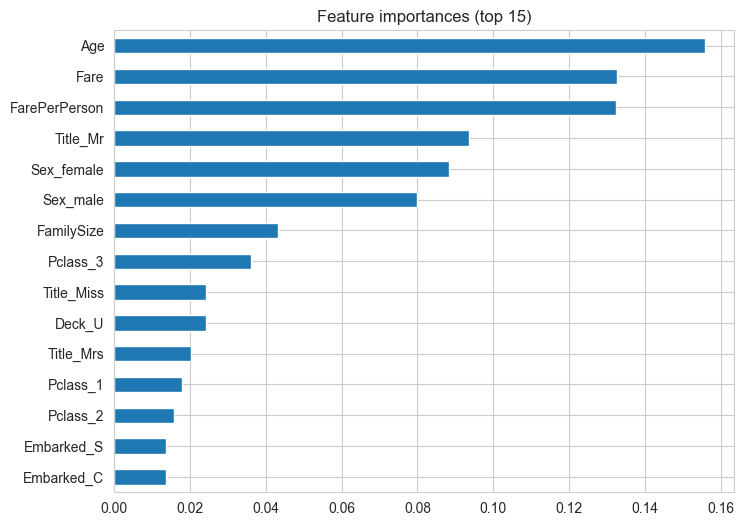

In [22]:
# %%
try:
    if chosen_model_name == 'RandomForest':
        clf = final_model.named_steps['clf']
        ohe = final_model.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
        cat_feature_names = list(ohe.get_feature_names_out(cat_cols))
        feat_names = num_cols + cat_feature_names
        importances = clf.feature_importances_
        fi = pd.Series(importances, index=feat_names).sort_values(ascending=False)
        print("Top features:\n", fi.head(15))
        plt.figure(figsize=(8,6))
        fi.head(15).plot(kind='barh')
        plt.gca().invert_yaxis()
        plt.title("Feature importances (top 15)")
        plt.show()
    else:
        print("Feature importances display implemented for RandomForest only.")
except Exception as e:
    print("Could not extract feature importances:", e)


In [23]:
# %% [markdown]
# ## 10) (Optional) Tune RandomForest quickly using RandomizedSearchCV
# Set run_tuning=True to execute (it will take longer).


In [24]:
# %%
run_tuning = False  # set to True to run tuning (time-consuming)
if run_tuning:
    from scipy.stats import randint
    rf = RandomForestClassifier(random_state=42)
    pipe = Pipeline(steps=[('preprocessor', preprocessor), ('clf', rf)])
    param_dist = {
        'clf__n_estimators': randint(100, 400),
        'clf__max_depth': randint(2, 15),
        'clf__min_samples_split': randint(2, 10),
        'clf__min_samples_leaf': randint(1, 6)
    }
    rs = RandomizedSearchCV(pipe, param_distributions=param_dist, n_iter=30, cv=skf, scoring='accuracy', random_state=42, n_jobs=-1, verbose=1)
    rs.fit(X, y)
    print("Best CV score:", rs.best_score_)
    print("Best params:", rs.best_params_)
    best_model = rs.best_estimator_
    best_preds = best_model.predict(X_test)
    pd.DataFrame({'PassengerId': test_ids, 'Survived': best_preds.astype(int)}).to_csv(os.path.join(DATA_DIR,'submission_tuned.csv'), index=False)
    print("Saved submission_tuned.csv")


In [25]:
# %% [markdown]
# ## 11) Save final model


In [26]:
# %%
joblib.dump(final_model, os.path.join(DATA_DIR, "final_model.joblib"))
print("Saved model to", os.path.join(DATA_DIR, "final_model.joblib"))


Saved model to C:\Users\Prajwal\Downloads\titanic\final_model.joblib
